In [1]:
%matplotlib inline

# Лабораторная работа №5, часть 1

In [2]:
from functools import partial

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from scipy.io import loadmat
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.svm import SVC

### Загрузка данных

In [3]:
DATA_1 = loadmat("ex5data1.mat")
X_1 = DATA_1["X"]
Y_1 = DATA_1["y"].reshape(-1)

print(f"DATA_1 Features shape: {X_1.shape}")
print(f"DATA_1 Outputs shape: {Y_1.shape}")
section_separator = "=" * 69
print(section_separator)


DATA_2 = loadmat("ex5data2.mat")
X_2 = DATA_2["X"]
Y_2 = DATA_2["y"].reshape(-1)

print(f"DATA_2 Features shape: {X_2.shape}")
print(f"DATA_2 Outputs shape: {Y_2.shape}")
print(section_separator)


DATA_3 = loadmat("ex5data3.mat")
X_3 = DATA_3["X"]
Y_3 = DATA_3["y"].reshape(-1)
X_3_VAL = DATA_3["Xval"]
Y_3_VAL = DATA_3["yval"].reshape(-1)

print(f"DATA_3 Features shape: {X_3.shape}")
print(f"DATA_3 Outputs shape: {Y_3.shape}")
print(f"DATA_3 Validation features shape: {X_3_VAL.shape}")
print(f"DATA_3 Validation outputs shape: {Y_3_VAL.shape}")


DATA_1 Features shape: (51, 2)
DATA_1 Outputs shape: (51,)
DATA_2 Features shape: (863, 2)
DATA_2 Outputs shape: (863,)
DATA_3 Features shape: (211, 2)
DATA_3 Outputs shape: (211,)
DATA_3 Validation features shape: (200, 2)
DATA_3 Validation outputs shape: (200,)


### Отображение входных данных

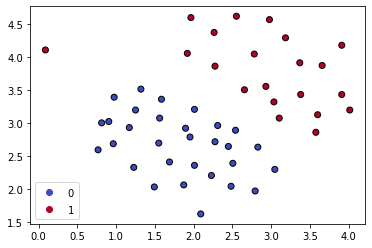

In [4]:
def display_inputs(x: np.ndarray, y: np.ndarray, ax: Axes = plt):
    path_collection = ax.scatter(
        x[:, 0], x[:, 1], c=y, cmap="coolwarm", edgecolors="black"
    )
    ax.legend(*path_collection.legend_elements(), loc="lower left")
    return path_collection


display_inputs(X_1, Y_1)
plt.show()

### Обучение классификатора с линейным ядром

In [5]:
lin_clf_c_1 = SVC(C=1.0, kernel="linear").fit(X_1, Y_1)
lin_clf_c_100 = SVC(C=100.0, kernel="linear").fit(X_1, Y_1)


Подготовка параметров для построения графиков разделяющих прямых

In [6]:

def decision_boundary_graph(
    x_min: np.ndarray,
    x_max: np.ndarray,
    clf: SVC,
    padding: float = 1.0,
    steps: int = 50,
    ax: Axes = plt,
):
    x_graph_val = np.linspace(x_min - padding, x_max + padding, steps)
    x_meshed = np.meshgrid(*x_graph_val.T)
    x_graph_matrix = np.column_stack(tuple(np.ravel(column) for column in x_meshed))
    x_dimensions = tuple(x_meshed[0].shape)
    prediction = np.reshape(clf.predict(x_graph_matrix), x_dimensions)
    ax.contourf(*x_meshed, prediction, cmap="coolwarm", alpha=0.6)


#### Графики разделяющих прямых

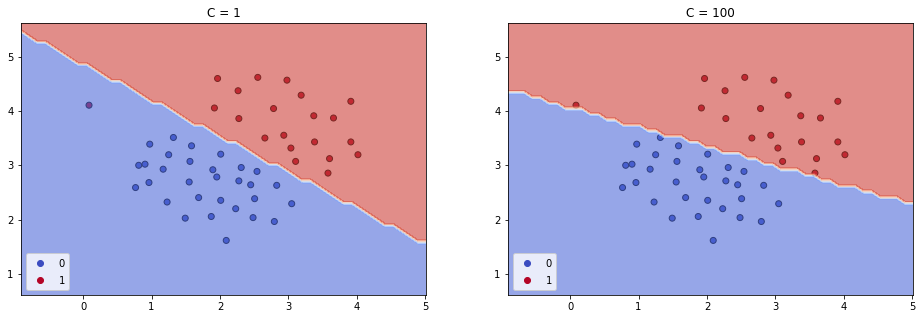

In [7]:
figure, (ax1_data_1, ax2_data_1) = plt.subplots(ncols=2, figsize=(16, 5))

X_1_MIN = np.min(X_1, axis=0)
X_1_MAX = np.max(X_1, axis=0)

for ax, clf, title in (
    (ax1_data_1, lin_clf_c_1, "C = 1"),
    (ax2_data_1, lin_clf_c_100, "C = 100"),
):
    ax.set_title(title)
    display_inputs(X_1, Y_1, ax)
    decision_boundary_graph(X_1_MIN, X_1_MAX, clf, ax=ax)

plt.show()


При малом значении C = 1 модель была больше подвержена регуляризации, было получено
большее расстояние между классами, однако присутствуют примеры данных,
которые полученной моделью были классифицированы неверно.

При большом значении C = 100 модель корректно определила классы для всех примеров,
но расстояние между классами уменьшилось. Дисперсия стала больше, а смещение - меньше.

### Функция вычисления Гауссова ядра
\begin{equation}
f_i = \exp
\left(
-\frac{\left\lVert x - l^{(i)} \right\rVert ^2}{2 \sigma^2}
\right)
\end{equation}

In [8]:
def similarity(x, l, sigma=1.0) -> float:
    return np.exp(np.sum(np.square(x - l), axis=1) / (-2 * (sigma ** 2)))


def gaussian_kernel(x, l, sigma=1.0):
    return np.column_stack(tuple(similarity(x, l_i, sigma) for l_i in l))


### Обучение классификатора SVM с использованием функции Гауссова ядра

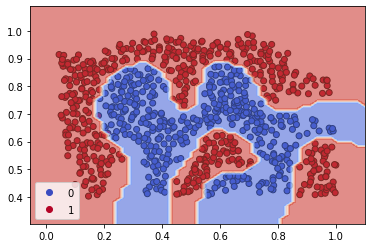

In [9]:
display_inputs(X_2, Y_2)

gauss_clf = SVC(C=10.0, kernel=partial(gaussian_kernel, sigma=0.1)).fit(X_2, Y_2)
decision_boundary_graph(
    np.min(X_2, axis=0), np.max(X_2, axis=0), gauss_clf, padding=0.1
)

plt.show()


### Выбор оптимальных значений для параметров $C$ и $\sigma^2$

In [10]:
test_fold = np.concatenate(
    (np.repeat(0, X_3.shape[0]), np.repeat(-1, X_3_VAL.shape[0]))
)
grid_search_clf = GridSearchCV(
    estimator=SVC(kernel="rbf"),
    param_grid={"C": np.arange(1, 101, 1), "gamma": np.arange(1, 21, 1)},
    cv=PredefinedSplit(test_fold),
    n_jobs=-1,
).fit(np.concatenate((X_3, X_3_VAL)), np.concatenate((Y_3, Y_3_VAL)))

print(f"Best params: {grid_search_clf.best_params_}")
print(f"Best score: {grid_search_clf.best_score_:.2%}")

Best params: {'C': 6, 'gamma': 10}
Best score: 94.79%


#### Отображение результатов

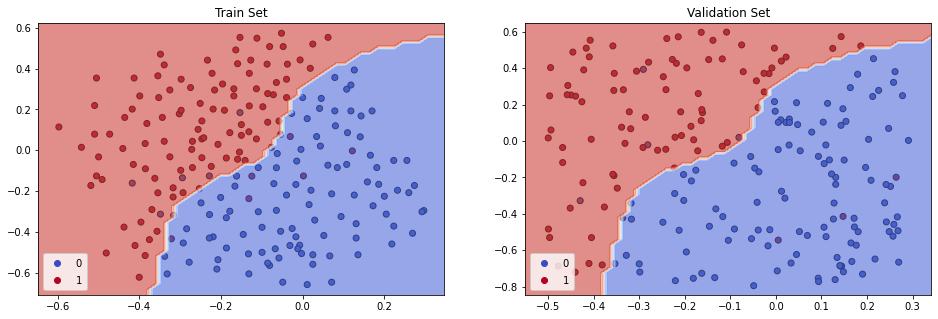

In [11]:
figure, (ax1_data_3, ax2_data_3) = plt.subplots(ncols=2, figsize=(16, 5))

for ax, x, y, title in (
    (ax1_data_3, X_3, Y_3, "Train Set"),
    (ax2_data_3, X_3_VAL, Y_3_VAL, "Validation Set"),
):
    ax.set_title(title)
    display_inputs(x, y, ax)
    decision_boundary_graph(
        np.min(x, axis=0), np.max(x, axis=0), grid_search_clf, ax=ax, padding=0.05
    )

plt.show()